In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from Map import Map
from Tabu import Tabu
from TwoStage import TwoStage
from L_shaped import MasterProblem as mp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl 
import matplotlib.cm as cm
import time
import networkx as nx
import matplotlib as mpl
from gurobipy import *
import csv

**Modelling Parameters**

In [3]:
rides = 5
bus = 2
scenarios = 20
MIPGap = 0.001
TimeLimit = 18000
probability = [0.7, 0.1, 0.15, 0.05]

**Defining the Map**

In [4]:
mappy = Map(rides, seed=200)

**Plotting Functions**

In [5]:
def plot_trend(ub,lb,base):
    x = list(range(len(ub)))
    figure = plt.figure()
    plt.plot(x,ub,label='upper-bound')
    plt.plot(x,[base]*len(ub),label='two-stage')
    plt.plot(x,lb,label='lower-bound')
    plt.annotate(int(ub[-1]),[x[-1],ub[-1]])
    plt.legend()
    plt.savefig('./figures/trend.png')
    plt.show()

colors = ['green','blue','yellow','red','pink'] 
def displaygraph(n, e, modname):
    for k in e.keys():
        for i, j in e[k]:
            plt.plot((n[i][0],n[j][0]),(n[i][1],n[j][1]), color=colors[k] ,marker='o', linewidth=2, linestyle='dashed')
    for i in n:
        plt.annotate(i,n[i],textcoords="offset points",xytext=(0,10),ha='center')
    plt.savefig('./figures/'+modname+'.png')
    plt.show()


#### Model formulation

In [6]:
def Mod1(aux=False):
    t1 = time.time()
    drpstw = mp(mappy,bus=bus,scenarios=scenarios, probability=probability)
    drpstw.initialize()
    drpstw.setMIP()
    drpstw.variables.th.obj=0
    if aux:
        drpstw.setLowerBound()
        for s in range(drpstw.scenarios):
            drpstw.submodel[s].model.params.MIPGap = MIPGap
#             drpstw.submodel[s].model.params.OutputFlag = 1
    else:
        drpstw.model.params.TimeLimit = TimeLimit
        drpstw.model.optimize()
    t1 = time.time() - t1
    return drpstw, t1

In [7]:
def Mod2(model=None):
    t2 = time.time()
    twosp = TwoStage(mappy, bus=bus, scenarios=scenarios, probability=probability)
    twosp.model.params.TimeLimit = TimeLimit
    if model is not None:
        for i,j,k in twosp.MP.variables.x.keys():
            twosp.MP.variables.x[i,j,k].start = model.variables.x[i,j,k].X
    twosp.optimize()
    t2 = time.time() - t2
    return twosp, t2

In [8]:
def Mod3():
    t3 = time.time()
    lshaped = mp(mappy, bus=bus, scenarios=scenarios, probability=probability)
    lshaped.initialize()
    lshaped.model.params.TimeLimit = TimeLimit
    lshaped.optimize()
    t3 = time.time() - t3
    return lshaped, t3

In [9]:
def Mod4(lshaped):
    t4 = time.time()
    if lshaped.submodel is not None:
        tabu = Tabu(lshaped,tabu_iterations=200, tabu_status=3, rtoptm=5, subset=20, tsp=False)
        tabu.tsp = True
    else:
        tabu = Tabu(lshaped,tabu_iterations=200, tabu_status=4, rtoptm=5, subset=20, tsp=True)
    tabu.tabuheuristic()
    t4 = time.time() - t4
    return tabu, t4

In [10]:
def Mod5(lshaped):
    t5 = time.time()
    tabutsp = Tabu(lshaped,tabu_itcerations=100, subset=10, tsp=True)
    tabutsp.tabuheuristic()
    t5 = time.time() - t5
    return tabutsp, t5

### Test Block

In [ ]:
TimeLimit = 18000
tests = [(3,2),(4,2),(5,2),(6,2),(7,2),(9,3),(10,3),(11,3),(13,4),(15,4),(18,5),(20,5),(22,6),(24,6),(25,7),(27,8)]
scenarioslist = [10,20,30]

with open('./Reports/Report.csv', 'w', newline='') as csv_file:
    write = csv.writer(csv_file, delimiter=',')
    write.writerow(('Rides','Bus','Scenarios','TSPObj','TSPGap','TSPTime','LshapeObj','LshapeSave','LshapeGap','LshapeTime','TabuObj','TabuSave','TabuTime'))
    for s in scenarioslist:
        scenarios = s
        for test in tests:
            rides, bus = test
            mappy = Map(rides)
            #Two-Stage
            try:    
                twostage, t1 = Mod2()
                if twostage.model.status in [2,9]:
                    twostageobj = twostage.model.ObjVal
                    twostagegap = twostage.model.MIPGap
                    twostagetime = t1
                else:
                    twostageobj = 'NA'
                    twostagegap = 'NA'
                    twostagetime = t1
            except GurobiError:
                twostageobj = 'Failed'
                twostagegap = 'Failed'
                twostagetime = 'Failed'
            #L-shaped
            try:    
                lshaped, t2 = Mod3()
                if lshaped.model.status in [2,9]:
                    lshapedobj = lshaped.model.ObjVal
                    lshapedsave = lshaped.variables.th.X
                    lshapedgap = lshaped.model.MIPGap
                    lshapedtime = t2
                else:
                    lshapedobj = 'NA'
                    lshapedgap = 'NA'
                    lshapedtime = t2
                    lshapedsave = 'NA'
            except GurobiError:
                lshapedobj = 'Failed'
                lshapedsave = 'Failed'
                lshapedgap = 'Failed'
                lshapedtime = 'Failed'
            #Tabu
            try:    
                tabu, t3 = Mod4(lshaped)
                tabuobj = tabu.best[-1]
                tabusave = tabu.best[-3]
                tabutime = t3
                
            except GurobiError:
                tabuobj = 'Failed'
                tabusave = 'Failed'
                tabutime = 'Failed'
            
            write.writerow((str(rides),
                            str(bus),
                            str(scenarios),
                            str(twostageobj),
                            str(twostagegap),
                            str(twostagetime),
                            str(lshapedobj),
                            str(lshapedsave),
                            str(lshapedgap),
                            str(lshapedtime),
                            str(tabuobj),
                            str(tabusave),
                            str(tabutime)))

In [ ]:
MIPGap = 0.001
tests = [(3,1),(4,1),(5,1),(6,2),(7,2),(8,2),(9,2)]
scenarioslist = [10,15,20]
for s in scenarioslist:
    scenarios = s
    for test in tests:
        rides, bus = test
        mappy = Map(rides)        
#         drpstw, t1 = Mod1()
#         objdrpstw = drpstw.model.ObjVal
        twosp, t2 = Mod2()
        objtwosp = twosp.model.ObjVal
        lshaped, t3 = Mod3() 
        objlshaped = lshaped.model.ObjVal
#         tabu, t4 = Mod4()
#         objtabu = tabu.best[-2]
        write = [
#             str(objdrpstw), str(t1),
            str(objtwosp), str(t2),
            str(objlshaped), str(t3),
#             str(objtabu), str(t4),
            str(scenarios),str(bus),str(rides)]
        with open('report.txt', 'a') as file:
            file.write('\n')
            for w in write:
                file.write(w)
                file.write(',')

### DARP-STW Model

#### Model Solution 

In [ ]:
drpstw, t1 = Mod1()

In [ ]:
nodes = mappy.node
edges = {k:[] for k in range(drpstw.bus)}
for i, j in drpstw.parameters.edges:
    for k in range(drpstw.bus):
        if drpstw.variables.x[i,j,k].X > 0.5:
            if j != drpstw.last:
                edges[k].append((i,j))
            else:
                edges[k].append((i,0))

objdrpstw = drpstw.model.ObjVal
displaygraph(nodes, edges,'DARP-STW')
nodes,edges

### Two-Stage Stochastic Model

#### Model Solution

In [ ]:
twosp, t2 = Mod2()

In [ ]:
nodes = mappy.node
edges = {k:[] for k in range(twosp.bus)}
for i, j in twosp.parameters.edges:
    for k in range(twosp.bus):
        if twosp.MP.variables.x[i,j,k].X > 0.5:
            if j != twosp.last:
                edges[k].append((i,j))
            else:
                edges[k].append((i,0))

objtwosp = twosp.model.ObjVal
displaygraph(nodes, edges,'Two-Stage')
nodes,edges

### L-Shaped Method

#### Model Solution

In [11]:
lshaped, t3 = Mod3()

Using license file C:\Users\lavkeshg\gurobi.lic
Academic license - for non-commercial use only
Changed value of parameter lazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter NodefileStart to 0.5
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter Presolve to 2
   Prev: -1  Min: -1  Max: 2  Default: -1
Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Parameter Heuristics unchanged
   Value: 0.05  Min: 0.0  Max: 1.0  Default: 0.05
Changed value of parameter TimeLimit to 18000.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
-58.3059212283606 -12.371540000000008
45.93433083383516 -5.039452543087464e-05
-57.18085543189045 -12.45680500000001
46.0651338510836 1.3410834191931613
-55.62857840694778 -14.236994999999997
45.10695039306903 3.7153669861212393
-53.558013182997456 -14.622376735721835
43.821823207565295 4.886186760289675
-49.023336614227446 -13.445430000000002
41.37758928741507 5.799682673187625
-3

In [ ]:
lshaped.LazyInt

In [ ]:
nodes = mappy.node
edges = {k:[] for k in range(lshaped.bus)}
for i, j in lshaped.parameters.edges:
    for k in range(lshaped.bus):
        if lshaped.variables.x[i,j,k].X > 0.5:
            if j != lshaped.last:
                edges[k].append((i,j))
            else:
                edges[k].append((i,0))
bounds = lshaped.getcancel()
objlshaped = lshaped.model.ObjVal
displaygraph(nodes, edges,'L-Shaped')
nodes,edges,bounds

In [ ]:
plot_trend(lshaped.upperbounds[2:],lshaped.lowerbounds[2:],0)

In [ ]:
mostcancel = {i: 0 for i in lshaped.parameters.pickup}
for i in lshaped.parameters.pickup:
    for s in range(lshaped.scenarios):
        mostcancel[i] += 2 - lshaped.submodel[s].sim.alpha[i] - lshaped.submodel[s].sim.alpha[i+lshaped.parameters.rides]
mostcancel = sorted(mostcancel.items(), key=lambda x: (x[1]))
mostcancel

In [12]:
lshaped.printsol()

Routing for bus 1
+---------+------+-------------+---------------+
| Pick-up | Drop | Pickup time | Drop-off time |
+---------+------+-------------+---------------+
|    6    |  7   |    9:36     |     10:04     |
+---------+------+-------------+---------------+
|    2    |  6   |    9:20     |     9:36      |
+---------+------+-------------+---------------+
|    0    |  1   |    8:18     |     8:24      |
+---------+------+-------------+---------------+
|    9    |  11  |    10:35    |     10:51     |
+---------+------+-------------+---------------+
|    1    |  4   |    8:24     |     8:46      |
+---------+------+-------------+---------------+
|    4    |  2   |    8:46     |     9:20      |
+---------+------+-------------+---------------+
|    7    |  9   |    10:04    |     10:35     |
+---------+------+-------------+---------------+
Routing for bus 2
+---------+------+-------------+---------------+
| Pick-up | Drop | Pickup time | Drop-off time |
+---------+------+-------------+-

In [ ]:
sum((1/scenarios)*lshaped.submodel[i].model.ObjVal for i in lshaped.submodel.keys())

### Tabu-Heuristic

#### Model Solution

In [13]:
tabu, t4 = Mod4(lshaped)

Building Initial Solution
Starting Heuristic
Neighborhood length: 5 (iteration 1)
321.89351381668445 800.8252932098392
Neighborhood length: 4 (iteration 2)
138.92479045318763 321.89351381668445
Neighborhood length: 3 (iteration 3)
138.92479045318763 138.92479045318763
Neighborhood length: 3 (iteration 4)
138.92479045318763 138.92479045318763
Neighborhood length: 3 (iteration 5)
138.92479045318763 138.92479045318763
Neighborhood length: 3 (iteration 6)
138.92479045318763 138.92479045318763
Neighborhood length: 3 (iteration 7)
97.36410153125571 138.92479045318763
Neighborhood length: 3 (iteration 8)
97.36410153125571 97.36410153125571
Neighborhood length: 3 (iteration 9)
97.36410153125571 97.36410153125571
Neighborhood length: 3 (iteration 10)
97.36410153125571 97.36410153125571
Neighborhood length: 3 (iteration 11)
97.36410153125571 97.36410153125571
Neighborhood length: 3 (iteration 12)
97.36410153125571 97.36410153125571
Neighborhood length: 3 (iteration 13)
97.36410153125571 97.36410

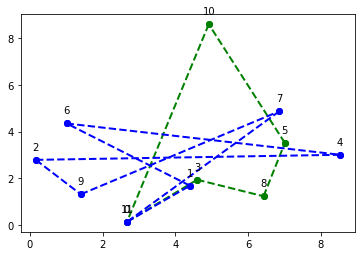

({0: (2.6671226260336733, 0.11472960500748308),
  1: (4.399705433090418, 1.672104054587421),
  2: (0.16226131011587097, 2.781366738635583),
  3: (4.597999247302336, 1.9285636878249712),
  4: (8.528244429906145, 3.0002455193093036),
  5: (7.008269160039364, 3.509502235742331),
  6: (1.0094211595822156, 4.3458724193158105),
  7: (6.856550495783891, 4.8700804482709135),
  8: (6.421958261391797, 1.2173880439760654),
  9: (1.3990110801878353, 1.3013328971009641),
  10: (4.9166847140006, 8.609822704622246),
  11: (2.6671226260336733, 0.11472960500748308)},
 {0: [(0, 3), (3, 8), (8, 5), (5, 10), (10, 11)],
  1: [(0, 1), (1, 6), (6, 4), (4, 2), (2, 9), (9, 7), (7, 11)]},
 {0: 0-->3-->8-->5-->10-->11,
  1: 0-->1-->6-->4-->2-->9-->7-->11,
  -1: 97.36410153125571,
  -2: 112.49164908331204,
  -3: -15.127547552056322})

In [14]:
nodes = mappy.node
edges = {k:[] for k in tabu.bus}
for k in tabu.bus:
    for i in tabu.best[k]:
        n = tabu.best[k][i]
        if i != tabu.model.last:
            edges[k].append((i,n.next.key))
objtabu = tabu.best[-2]
displaygraph(nodes, edges,'Tabu')    
nodes,edges, tabu.best

In [ ]:
# tabu.best[0] = LinkedList()
# [0,1,4,2,6,7,9,11]
for i in tabu.bestcandidate[0]:
    print(tabu.bestcandidate[0][i].bus)

In [ ]:
tabutsp, t5 = Mod5()

In [ ]:
nodes = mappy.node
edges = {k:[] for k in tabu.bus}
for k in tabutsp.bus:
    for i in tabutsp.best[k]:
        n = tabutsp.best[k][i]
        if i != tabutsp.model.last:
            edges[k].append((i,n.next.key))
objtabutsp = tabutsp.best[-2]
displaygraph(nodes, edges,'TabuTSP')    
nodes,edges, tabutsp.best

In [ ]:
t3,t4

In [ ]:
mappy.pickup_time

In [ ]:
# print(twosp.sim.alpha)
lshaped.printsol(lshaped.submodel)

In [ ]:
nodes = mappy.node
edges = {k:[] for k in range(lshaped.bus)}
for i, j in lshaped.parameters.edges:
    for k in range(lshaped.bus):
        if lshaped.submodel[3].variables.xs[i,j,k].X > 0.5:
            if i == 0 and j == 9:
                continue
            if j != lshaped.last:
                edges[k].append((i,j))
            else:
                edges[k].append((i,0))
bounds = lshaped.getcancel()
objlshaped = lshaped.model.ObjVal
displaygraph(nodes, edges,'L-Shaped')
nodes,edges

In [ ]:
drpstw